In [2]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.fftpack import fft, ifft

# Fornberg's method for computing the conformal map from the interior of the unit disk to 
# the interior of a smooth, closed curve. It is a Newton-like method for
# computing the boundary correspondence. An inner linear system is derived for the New-
# ton updates based on the condition that the negatively indexed Fourier coefficients of the
# (periodic) boundary values must be 0 for the function to be analytic inside the disk

def fornintsp(n, itmax, x, y):
    center = 0
    n2 = n // 2
    x1, x2, x3, y1, y2, y3, h, tl = spline(x, y)  # You need to define spline function
    s = tl * np.arange(n) / n

    # Start of Fornberg iteration loop
    for it in range(itmax):
        f, e = interp1(x, x1, x2, x3, y, y1, y2, y3, h, tl, s)
        ne = np.abs(e)
        e = e / ne
        c = fft(f)
        c[1:n2+1] = 0
        c = ifft(c).real
        a1 = np.real(center * np.conj(e))  # Fix f(0) = center
        b = -np.real(c * np.conj(e)) + a1

        # Conjugate Gradient Method
        v = np.zeros(n)
        r = b
        p = r
        rr = np.dot(r, r)

        # The start of conjugate gradient iteration
        for _ in range(n):
            if np.linalg.norm(p) < 1.0e-14:
                break
            c = e * p
            c = fft(c)
            c[1:n2+1] = 0
            c = ifft(c).real
            q = np.real(c * np.conj(e))
            q[0] += p[0] * n / 4  # Add Q*p, Q rank 1 to fix f(1)
            alpha = rr / np.dot(p, q)
            v += alpha * p
            r -= alpha * q
            rr1 = np.dot(r, r)
            if np.sqrt(rr1) < 1.0e-14:
                break
            beta = rr1 / rr
            p = r + beta * p
            rr = rr1

        sl = s
        s += v / ne
        erri = np.linalg.norm(s - sl, np.inf)

    return f, s, erri

def spline(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    if np.abs(x[0] - x[-1]) > 100 * np.finfo(float).eps or np.abs(y[0] - y[-1]) > 100 * np.finfo(float).eps:
        x = np.append(x, x[0])
        y = np.append(y, y[0])

    n1 = len(x)
    n = n1 - 1
    dx = np.diff(x)
    dy = np.diff(y)
    h = np.sqrt(dx**2 + dy**2)
    tl = np.sum(h)
    h = np.append(h, h[0])
    p = h[:n]
    q = h[1:]
    a = q / (p + q)
    b = 1 - a
    data = np.vstack((b[-1], np.ones(n-1), a[1:], 2*np.ones(n), np.zeros(n-1), np.ones(n-1), a[:-1], b[0]))
    diags = np.array([1-n, -1, 0, 1, n-1])
    c = np.diag(data[2], 0) + np.diag(data[1], 1) + np.diag(data[0], n-1) + np.diag(data[3], -1) + np.diag(data[4], -n+1)
    d1 = 3 * (a * dx / p + b * np.append(dx[1:], x[1] - x[-1]) / q)
    x1 = np.linalg.solve(c, d1)
    x1 = np.append(x1, x1[0])

    d = 3 * (a * dy / p + b * np.append(dy[1:], y[1] - y[-1]) / q)
    y1 = np.linalg.solve(c, d)
    y1 = np.append(y1, y1[0])

    x2 = np.zeros(n1)
    y2 = np.zeros(n1)
    x2[1:-1] = 2 * (x1[:n] + 2 * x1[1:] - 3 * dx / p) / p
    y2[1:-1] = 2 * (y1[:n] + 2 * y1[1:] - 3 * dy / p) / p
    x2[0] = x2[-1]
    y2[0] = y2[-1]

    x3 = np.diff(x2) / p
    x3 = np.append(x3, x3[0])
    y3 = np.diff(y2) / p
    y3 = np.append(y3, y3[0])

    return x1, x2, x3, y1, y2, y3, h, tl


def interp1(x, x1, x2, x3, y, y1, y2, y3, h, tl, s):
    n1 = len(x)
    nn = n1 - 1
    n = len(s)
    s = s - np.floor(s / tl) * tl
    cumsumh = np.hstack((0, np.cumsum(h[:nn])))
    ppx = CubicSpline(cumsumh, np.hstack((x3[:nn] / 6, x2[:nn] / 2, x1[:nn], x[:nn])))
    ppy = CubicSpline(cumsumh, np.hstack((y3[:nn] / 6, y2[:nn] / 2, y1[:nn], y[:nn])))
    fval = ppx(s) + 1j * ppy(s)
    ppdx = CubicSpline(cumsumh, np.hstack((x3[:nn] / 2, x2[:nn], x1[:nn])))
    ppdy = CubicSpline(cumsumh, np.hstack((y3[:nn] / 2, y2[:nn], y1[:nn])))
    fder = ppdx(s) + 1j * ppdy(s)
    return fval, fder

# Projection method - Wegmann survey p. 390
N = 512
alpha = 0.8
iter = 4000
t = 2 * np.pi * np.arange(N) / N
S = t

eta = lambda S: np.cos(S) + 1j * alpha * np.sin(S)
etadot = lambda S: -np.sin(S) + 1j * alpha * np.cos(S)

for k in range(iter):
    etas = eta(S)
    B = fft(etas) / N
    Bn = np.concatenate(([2 * B[0]], [1j * np.imag(B[1])], np.zeros(N//2-1), [1j * np.imag(B[N//2+1])], 2 * B[N//2+2:]))
    gk = ifft(Bn)
    etad = etadot(S)
    U = -np.real(gk / etad)
    S = S + U
    print(np.linalg.norm(U, np.inf))

etas = eta(S)
B = fft(etas) / N
Bp = np.concatenate(([0], np.real(B[1]), B[2:N//2+1], np.real(B[N//2+1]), np.zeros(N//2-2)))
etat = eta(t)

# Define the remaining functions (spline, interp1) for complete functionality

0.00043945308404714454
0.0004385731849585147
0.00043769495414558874
0.00043681838940079265
0.0004359434885109294
0.00043507024925726323
0.000434198669415612
0.0004333287467564365
0.00043246047904492424
0.00043159386404107694
0.000430728899499802
0.000429865583170992
0.0004290039127996119
0.0004281438861257802
0.00042728550088485894
0.00042642875480752786
0.0004255736456198716
0.00042472017104345995
0.00042386832879543054
0.0004230181165885626
0.0004221695321313606
0.0004213225731281348
0.00042047723727907095
0.0004196335222803179
0.00041879142582405983
0.00041795094559858456
0.0004171120792883727
0.0004162748245741603
0.00041544342262413993
0.0004146138916929725
0.00041378593494104923
0.0004129595501980748
0.0004121347352895832
0.00041131148803701855
0.0004104898062578025
0.00040966968776541036
0.00040885113036944745
0.00040803413187571146
0.00040721869008626926
0.00040640480279952653
0.00040559246781030127
0.00040478168290988093
0.0004039724458861093
0.0004031647545234387
0.0004023586

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [3]:
import numpy as np

# Grassman's method for computing conformal maps
# not completely finished yet

def circle(f, im1, ca, r):
    zr = 0.5 * ((ca + r) * (ca - r) + 1) / ca
    zi = np.sqrt(1 - zr**2)
    z1 = zr + 1j * zi
    z2 = np.conj(z1)
    d1 = np.imag(np.log(z1))
    z3 = z1 - ca
    d2 = np.imag(np.log(z3))
    d = np.pi - d2 + d1
    if ca < 0:
        d = d1 - d2
    tm = (f[im1] - z2) / (f[im1] - z1)
    t0 = tm * (z1 / z2)
    t1 = tm * (1 - z1) / (1 - z2)
    a = np.pi / d
    t0 = np.exp(a * np.log(t0))
    t01 = np.conj(t0)
    t1 = np.exp(a * np.log(t1))
    tm1 = (t1 - t01) / (t1 - t0)
    f = tm * (f - z1) / (f - z2)
    f = np.exp(a * np.log(f))
    f = tm1 * (f - t0) / (f - t01)
    return f, t0, tm1, z1, tm, a

def koebe(f, a):
    n = len(f)
    b = np.sqrt(-a)
    f1 = (f[0] - a) / (1 - a * f[0])
    branch = np.sqrt(f1)
    for i in range(n):
        f1 = (f[i] - a) / (1 - a * f[i])
        branch = np.sqrt(f1) if i == 0 else np.sqrt(f1 * branch)
        f[i] = (branch - b) / (1 - b * branch)
    return f

def grass(f, igm, gamma):
    a = np.zeros(igm)
    ig = np.zeros(igm)
    am1 = np.zeros(igm + 1)
    c1 = np.zeros(igm)
    t0 = np.zeros(igm)
    tm1 = np.zeros(igm)
    z1 = np.zeros(igm)
    tm = np.zeros(igm)
    for k in range(igm):
        fm = np.min(f)
        im1 = np.argmin(f)
        am1[k] = abs(fm)
        f, c1[k], ca, r = sector(f, im1)
        cm = abs(ca) + r
        if cm > 1:
            ig[k] = 1
            f, t0[k], tm1[k], z1[k], tm[k], a[k] = circle(f, im1, ca, r)
        elif cm <= 1:
            ig[k] = 2
            a[k] = ca + gamma * r
            f = koebe(f, a[k])
    f1 = f[0]
    f = f / f1
    am1[igm] = np.min(abs(f))
    return f, ig, c1, t0, tm1, z1, tm, a, f1, am1

def invcir(f, t0, tm1, z1, tm, a):
    f = (np.conj(t0) * f - t0 * tm1) / (f - tm1)
    f = np.exp((np.log(-1j * f) + 1j * 0.5 * np.pi) / a)
    f = (np.conj(z1) * f - z1 * tm) / (f - tm)
    return f

def invgra(f, ig, igm, c1, t0, tm1, z1, tm, a, f1):
    f = f1 * f
    for k in range(igm - 1, -1, -1):
        if ig[k] == 1:
            f = invcir(f, t0[k], tm1[k], z1[k], tm[k], a[k])
        elif ig[k] == 2:
            f = invkoe(f, a[k])
        f = np.conj(c1[k]) * f
    return f


C:\Users\Nate\AppData\Local\Temp\ipykernel_1572\1404872905.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  f[0, :] = 0.1 + 0.9 * alpha / (alpha * cs + 1j * ss)
C:\Users\Nate\AppData\Local\Temp\ipykernel_1572\1404872905.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  f[1, :] = -1 + 1.2j + 0.8 * alpha / (alpha * cs + 1j * ss)
C:\Users\Nate\AppData\Local\Temp\ipykernel_1572\1404872905.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  f[2, :] = -2 + 0.8 * alpha / (alpha * cs + 1j * ss)
C:\Users\Nate\AppData\Local\Temp\ipykernel_1572\1404872905.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  f[3, :] = -0.5 - 1.5j + cs - 0.6j * ss


AttributeError: module 'matplotlib.pyplot' has no attribute 'hold'

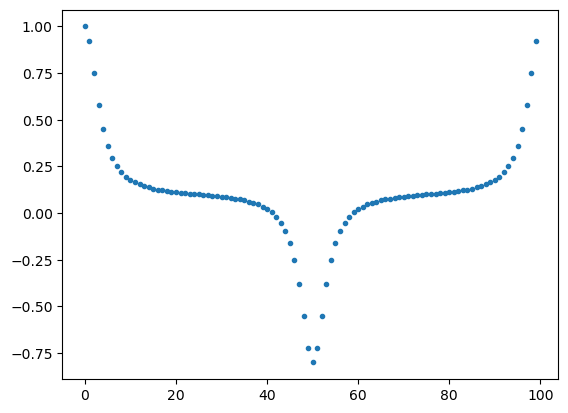

In [7]:
import matplotlib.pyplot as plt

# Example usage
N = 100  # number of points on boundary (counterclockwise)
igm = 6  # number of grass maps
mc = 4   # connectivity = number of boundary curves
f = np.zeros((mc, N))  # points on boundaries
d = np.zeros(mc)  # centers of circles
r = np.zeros(mc)  # radii of circles
gamma = 0.9

# Example of mc boundary curve
t = 2 * np.pi * np.arange(N) / N
alpha = 0.2
cs = np.cos(t)
ss = np.sin(t)
f[0, :] = 0.1 + 0.9 * alpha / (alpha * cs + 1j * ss)
f[1, :] = -1 + 1.2j + 0.8 * alpha / (alpha * cs + 1j * ss)
f[2, :] = -2 + 0.8 * alpha / (alpha * cs + 1j * ss)
f[3, :] = -0.5 - 1.5j + cs - 0.6j * ss

plt.figure(1)
for n in range(mc):
    plt.plot(f[n, :], '.')
    plt.hold(True)
plt.axis('equal')

for n in range(mc):
    d[n] = np.sum(f[n, :]) / N
    r[n] = np.min(np.abs(f[n, :] - d[n]))
    f[n, :] = r[n] / (f[n, :] - d[n])

for n in range(mc):
    f, ig, c1, t0, tm1, z1, tm, a, f1, am1 = grass(f, n, igm, gamma)
    f = d[n] + 1 / f
    plt.figure(n + 2)
    for j in range(mc):
        plt.plot(f[j, :], '.')
        plt.hold(True)
    plt.axis('equal')
plt.hold(False)

g = f[:, ::-1]
fplot = fornextspmc(g)
Nf = len(fplot[:, 0])
fg = fplot[Nf::-1, :].T
f = fg

for n in range(mc - 1, -1, -1):
    f = 1 / f